In [1]:
pip install opencv-python

  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import deque

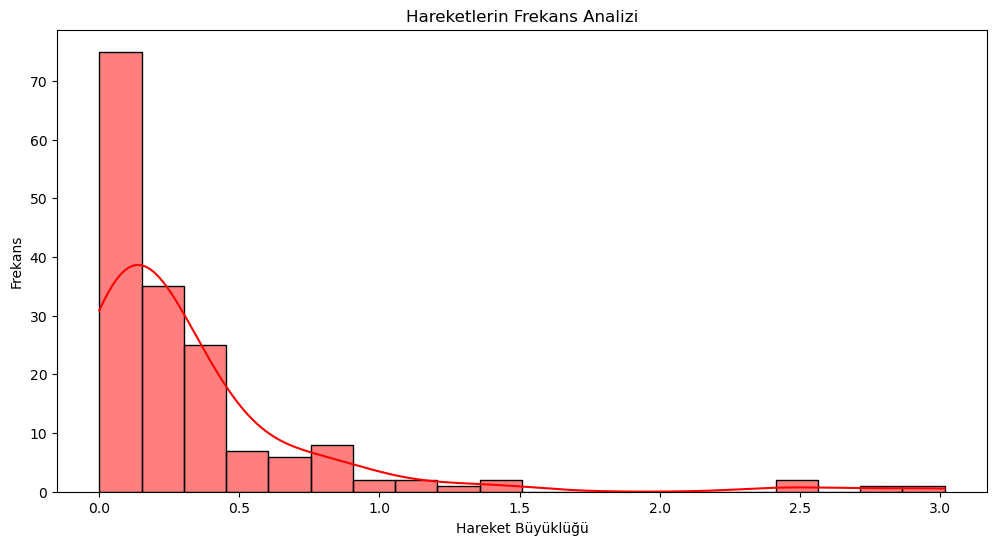

In [12]:
video=cv2.VideoCapture(0)

lower_skin=np.array([0, 30, 60],dtype=np.uint8) #dtype=np.uint8 ile dizilerin elemanları 0 ile 255 arasındaki sayılar olarak tutuluyor.
upper_skin=np.array([20, 150, 255],dtype=np.uint8)

#Hareketleri tespit etmek için optik akış (optical flow) yöntemini kullanmalıyız.
#OpenCV'nin cv2.calcOpticalFlowFarneback fonksiyonunu kullanarak kareler arasındaki hareketi analiz edeceğiz
ret, prev_frame = video.read()
prev_frame = cv2.flip(prev_frame, 1)
prev_gri = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

hareket_buyukluk=[]
ret=True
while ret:
    ret,frame=video.read()
    if not ret:
        break
    # Görüntüyü aynalama (daha doğal bir görüntü için)
    frame=cv2.flip(frame,1)
    
    #Maskeleme işlemi yaparken hsv formatına çevirmeliyiz
    hsv=cv2.cvtColor(frame,cv2.COLOR_BGR2HSV)
    mask= cv2.inRange(hsv,lower_skin,upper_skin) #cilt rengini tespit ettik yani renk tabanlı eşikleme yaptık
    
    # Gürültü azaltma için morfolojik işlemler
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    """# Gürültüyü azaltmak için önce erosion 
    mask = cv2.erode(mask, kernel, iterations=2)
    #Boşlukları doldurmak için dilation 
    mask = cv2.dilate(mask, kernel, iterations=2) 
    #mask ismini sürekli güncelleyerek bellek tasarufu yaptık"""
    
    result=cv2.bitwise_and(frame,frame,mask=mask)
    
    #** Hareket Analizi-Optik Akış
    gri = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)   # Şimdiki kareyi griye çevir
    flow = cv2.calcOpticalFlowFarneback(prev_gri, gri, None, 0.5, 3, 15, 3, 5, 1.2, 0) # hareket vektörlerini hesaplar.
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  #vetörleri kordinat sistemine çevirdi.
    hareket_buyukluk.append(np.mean(mag))

    # Optik Akışı Görselleştirme
    hsv_optik_akis=np.zeros_like(frame)
    hsv_optik_akis[...,1]=255
    hsv_optik_akis[...,0]=ang*180/np.pi/2
    hsv_optik_akis[...,2]=cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX) 
    optik_akis=cv2.cvtColor(hsv_optik_akis, cv2.COLOR_HSV2BGR)
    
    #cv2.imshow("Orijinal", frame)
    #cv2.imshow("Maske", mask)
    #cv2.imshow("Sonuç", result)  
    cv2.imshow("Hareket Gorsellestirme", optik_akis)
    
    # Bir sonraki kare için önceki kareyi güncelle
    prev_gri = gri.copy()
    
    # Çıkış için 'q' tuşuna bas
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
   
# Kamerayı kapat ve pencereleri temizle
video.release()
cv2.destroyAllWindows()

plt.figure(figsize=(12,6))
sns.histplot(hareket_buyukluk, bins=20 ,kde=True, color='red')
plt.xlabel('Hareket Büyüklüğü')
plt.ylabel('Frekans')
plt.title("Hareketlerin Frekans Analizi")
plt.show()
